# 군집분석 성능평가

> iris 데이터셋

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# 내장된 컬러맵, 컬러맵 처리 유틸리티
from matplotlib import cm

### [2] 데이터 가져오기

In [2]:
origin: DataFrame = my_read_excel(path="https://data.hossam.kr/mldata/iris.xlsx", 
                                  categories=['Species'], info=False)

## #02. 데이터 전처리

### [1] MinMax Scaling

In [3]:
df = my_minmax_scaler(origin, yname = 'Species')
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,0.222222,0.625000,0.067797,0.041667,setosa
1,0.166667,0.416667,0.067797,0.041667,setosa
2,0.111111,0.500000,0.050847,0.041667,setosa
3,0.083333,0.458333,0.084746,0.041667,setosa
4,0.194444,0.666667,0.067797,0.041667,setosa
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,virginica
146,0.555556,0.208333,0.677966,0.750000,virginica
147,0.611111,0.416667,0.711864,0.791667,virginica
148,0.527778,0.583333,0.745763,0.916667,virginica


## #03. 클러스터링

### [1] 클러스터링 군집 모형 구현

#### (1) 종속변수를 제외한 나머지 변수 추출

In [4]:
df2 = df.drop('Species', axis =1)
df2

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667
146,0.555556,0.208333,0.677966,0.750000
147,0.611111,0.416667,0.711864,0.791667
148,0.527778,0.583333,0.745763,0.916667


#### (2) 군집 모형 구현

In [5]:
estimator = KMeans(n_clusters=3, random_state=0)
estimator.fit(df2)

KMeans(n_clusters=3, random_state=0)

#### (3) 군집화 결과를 데이터프레임에 추가

In [6]:
cluster = estimator.predict(df2)

result_df = df2.copy()
result_df['cluster'] = cluster
result_df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster
0,0.222222,0.625000,0.067797,0.041667,1
1,0.166667,0.416667,0.067797,0.041667,1
2,0.111111,0.500000,0.050847,0.041667,1
3,0.083333,0.458333,0.084746,0.041667,1
4,0.194444,0.666667,0.067797,0.041667,1
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,2
146,0.555556,0.208333,0.677966,0.750000,0
147,0.611111,0.416667,0.711864,0.791667,2
148,0.527778,0.583333,0.745763,0.916667,2


#### (4) 각 군집의 중심점

In [7]:
estimator.cluster_centers_

array([[0.44125683, 0.30737705, 0.57571548, 0.54918033],
       [0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.70726496, 0.4508547 , 0.79704476, 0.82478632]])

### [2] 군집 결과 시각화

중심점 좌표 추가함

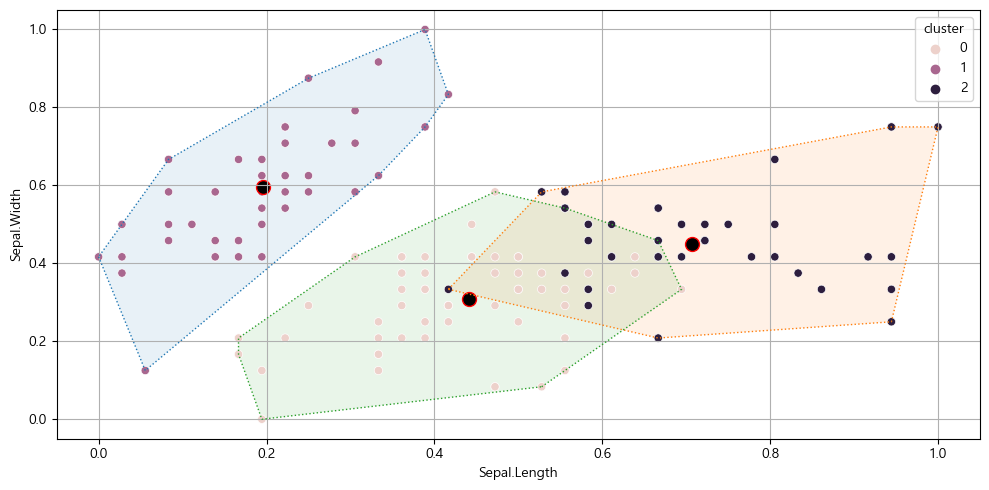

In [8]:
my_convex_hull(data = result_df, xname = 'Sepal.Length', yname = 'Sepal.Width', hue = 'cluster',
               callback=lambda ax: ax.scatter(
                   estimator.cluster_centers_[:,0],
                   estimator.cluster_centers_[:,1],
                   marker = 'o',
                   c="black",
                   alpha=1,
                   s=100,
                   edgecolor="red",
               ))

## #04. 군집의 성능 평가

최적의 `k`값을 찾기 위한 과정

### [1] Inertia (이너셔)

K-means 클러스터링의 성능 지표

각 샘플과 중점이 이동하는 자취 사이의 평균 제곱거리 측정값

Inertia값은 클러스터 수와 반비례 관계.

**클러스터 수를 늘려가면서 반복적으로 실행하면 값이 점점 작아진다.**

클러스터 수가 늘어감에 이너셔가 급격히 감소하고 어느 지점부터는 완만하게 감소하는 지점이 생기는데 이 지점이 최적 클러스터 수를 의미한다.(=엘보우(Elbow))

#### (1) `2~10`까지 군집의 수를 늘려가면서 Inertia값 수집

In [9]:
klist = list(range(2, 11))
inertia = []

for k in klist:
    estimator = KMeans(n_clusters=k, random_state=0)
    estimator.fit(X=df2)
    inertia.append(estimator.inertia_)
    
inertia

[12.127790750538196,
 6.982216473785236,
 5.516933472040369,
 4.5839407993118995,
 3.97531961342726,
 3.4724796020491944,
 3.164979639986039,
 2.8051380535035024,
 2.523232464943935]

#### (2) Inertia 값 시각화

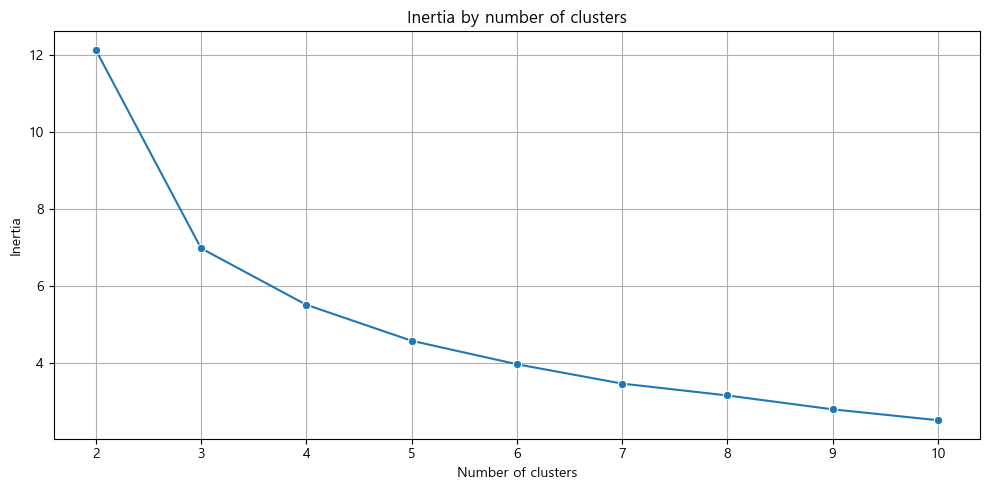

In [10]:
def my_callback(ax):
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Inertia")
    ax.set_title("Inertia by number of clusters")
    
my_lineplot(df = None, xname =klist, yname = inertia, marker = "o", callback=my_callback)

> x축의 값이 3인 지점부터 감소가 완만하게 진행되는 것으로 보인다. 그러므로 최적의 클러스터 수는 3으로 판단할 수 있다.

#### (3) Elbow Point 계산

##### 변화율 계산

In [11]:
change_rates = [0]
for i in range(1, len(inertia)):
    change_rate = (inertia[i] - inertia[i-1]) / inertia[i-1]
    change_rates.append(change_rate)

change_rates

[0,
 -0.424279605625997,
 -0.20985929142218357,
 -0.16911435989881787,
 -0.13277247951718757,
 -0.12649046121465185,
 -0.08855342501700864,
 -0.1136947555479769,
 -0.10049615497799791]

##### 변화율의 평균

In [12]:
avg_change_rate = np.mean(change_rates)
avg_change_rate

-0.15169561480242458

##### 평균 변화율보다 크게 감소하는 첫 번째 지점 찾기

In [13]:
elbow_point = next((i for i, rate in enumerate(change_rates) if rate < avg_change_rate), None)
elbow_point

1

##### 최적의 군집수

In [14]:
best_k = klist[elbow_point]
best_k

3

#### (4) Elbow Point를 포함한 Inertia 시각화

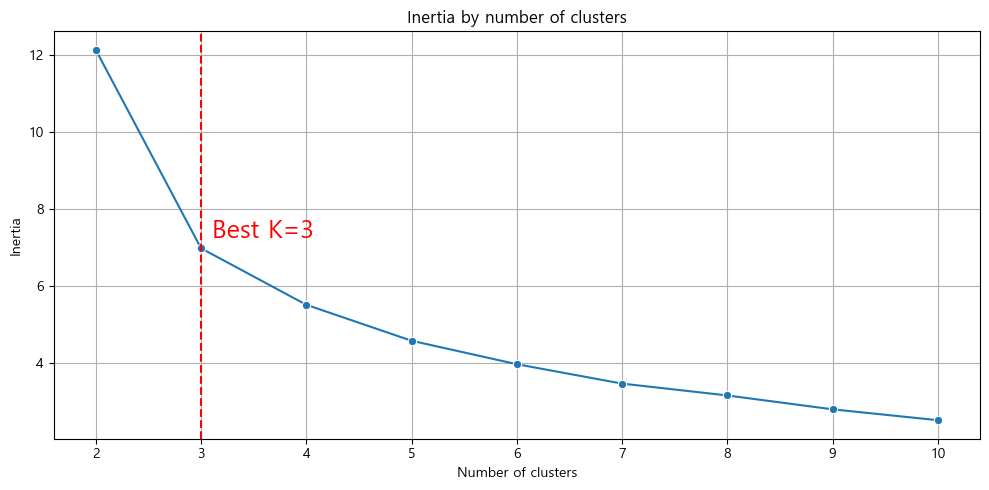

In [15]:
def my_callback(ax):
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Inertia')
    ax.set_title('Inertia by number of clusters')
    ax.axvline(x=klist[elbow_point], color='r', linestyle='--')

    ax.text(
        best_k+0.1, inertia[elbow_point]+0.1, "Best K=%d" % best_k, fontsize=18, ha="left", va="bottom", color="r"
    )

my_lineplot(df=None, xname=klist, yname=inertia, marker="o", callback=my_callback)

### [2] 실루엣 점수(계수)

각 군집간의 거리가 얼마나 효율적으로 분리되었는지를 나타내는 지표

효율적 분리: 어떤 한 점이 다른 군집과는 멀리 떨어져 있고, 동일 군집끼리는 서로 가깝게 잘 뭉쳐있다는 의미

개별 데이터가 같은 군집과는 얼마나 가깝고, 다른 군집의 데이터와는 얼마나 멀리 분리되어 있는가를 나타는 값.

각각의 데이터 포인터마다 존재하는 값

sklearn은 전체 실루엣 점수의 평균값을 반환나는 `silhouette_score()`함수를 제공한다.

리턴값은 `-1~1`의 범위를 가지며 `1`에 가까울 수록 좋은 군집으로 본다.

`0`인 경우는 클러스터가 겹치는 것을 의미

음수값은 일반적으로 샘플이 잘못된 클러스터에 할당되었음을 의미.

#### (1) 각 데이터 포인트의 실루엣 계수 계산

In [16]:
silhouette_samples(X=df2, labels=cluster, metric='euclidean')

array([0.79347482, 0.70973136, 0.76237793, 0.7257315 , 0.78692945,
       0.66218237, 0.75897165, 0.79472986, 0.64055474, 0.73946025,
       0.73540441, 0.78351441, 0.71021692, 0.66415815, 0.61666756,
       0.51541913, 0.67837458, 0.78627881, 0.64045393, 0.73938586,
       0.73093854, 0.74178509, 0.74912282, 0.6942033 , 0.75594482,
       0.69395379, 0.75844053, 0.78218394, 0.7814923 , 0.75396065,
       0.73568776, 0.71236073, 0.66264862, 0.61371799, 0.74185844,
       0.76558606, 0.73110902, 0.77878285, 0.67602776, 0.78997325,
       0.78917531, 0.38986402, 0.72009413, 0.68367323, 0.69302485,
       0.69705284, 0.74154706, 0.7509303 , 0.75022163, 0.78650903,
       0.01476308, 0.22682044, 0.0650627 , 0.55303568, 0.31937392,
       0.58661177, 0.11211165, 0.31387513, 0.32766896, 0.5545476 ,
       0.36363269, 0.50206024, 0.49945109, 0.4818992 , 0.56297865,
       0.19869893, 0.5027267 , 0.57609779, 0.40970738, 0.58933932,
       0.15428253, 0.55664059, 0.3776135 , 0.52022403, 0.44562

#### (2) 전체 데이터의 실루엣 계수에 대한 평균 스코어

보통 `0.5`가 넘으면 꽤 좋은 수치라고 함

In [17]:
silhouette_score(X=df2, labels=cluster, metric='euclidean')

0.5047687565398589

#### (3) 실루엣 스코어 시각화

> 출처: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [18]:
def visualize_silhouette(estimator, X_features, cluster_labels, n_cluster): 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    sil_avg = silhouette_score(X=X_features, labels=cluster_labels)
    sil_values = silhouette_samples(X=X_features, labels=cluster_labels)

    y_lower = 10
    plt.suptitle('Number of Cluster : '+ str(n_cluster)+', ' \
                        'Silhouette Score :' + str(round(sil_avg,3)) )
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
    for i in range(n_cluster):
        ith_cluster_sil_values = sil_values[cluster_labels==i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                            facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=sil_avg, color="red", linestyle="--")


      # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_cluster)
    ax2.scatter(
        X_features[X_features.columns[0]], X_features[X_features.columns[1]], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = estimator.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="r",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.show()
    plt.close()

#### (4) `2~10`까지 클러스터 수를 늘리면서 실루엣 점수 수집

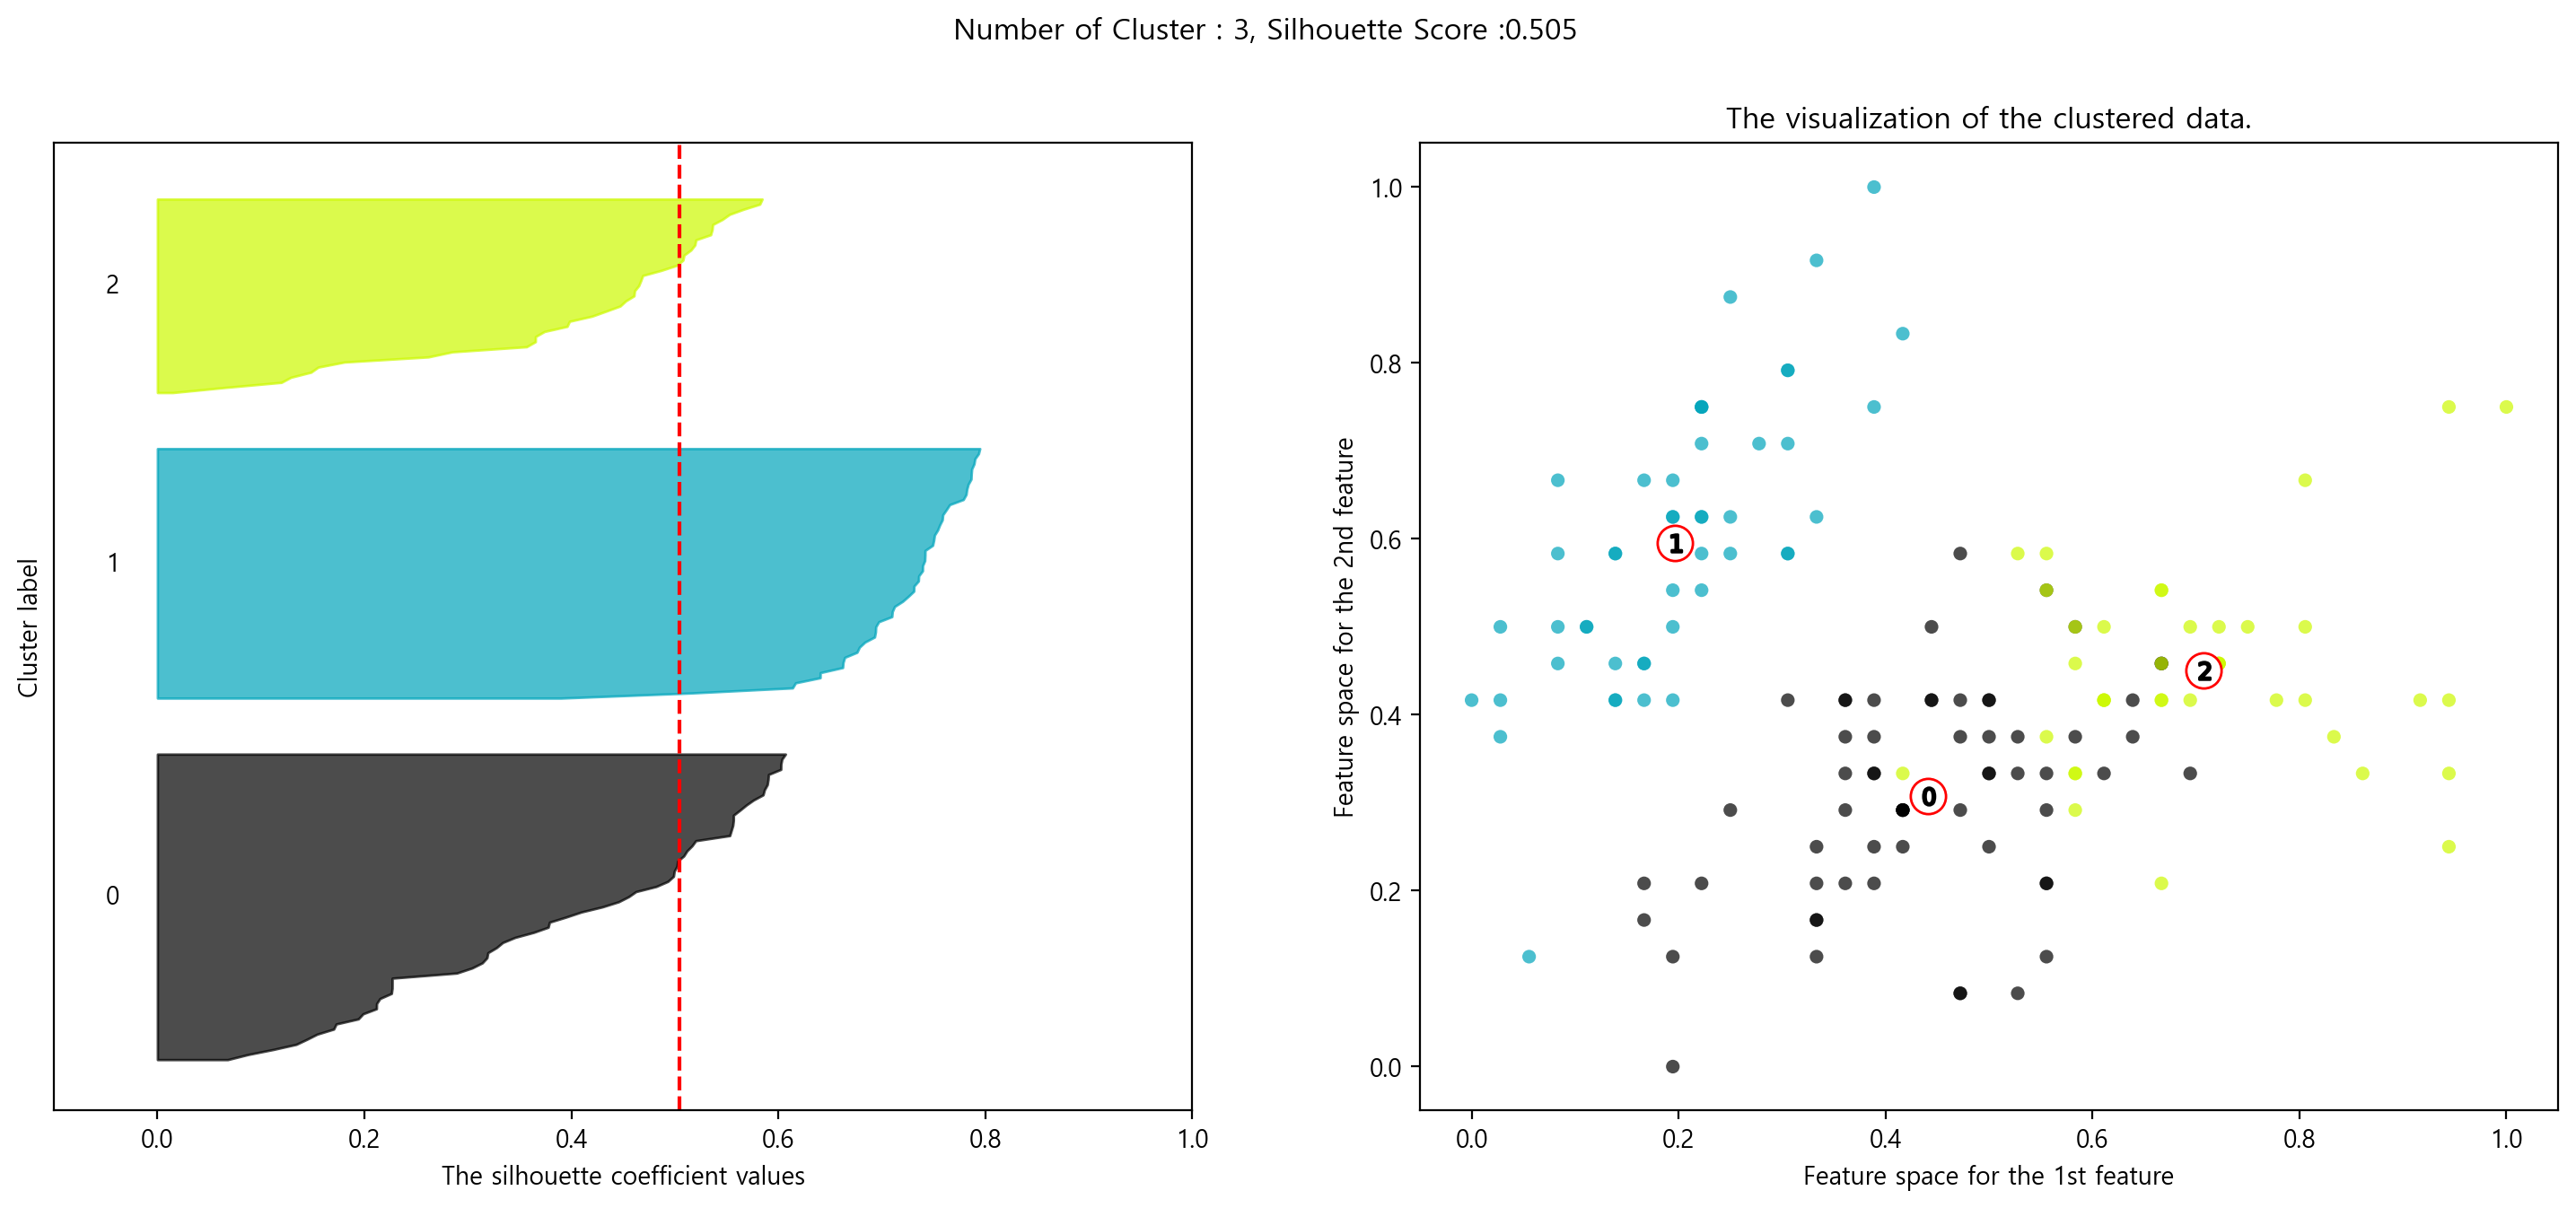

In [19]:
estimator = KMeans(n_clusters=best_k, random_state=0)
estimator.fit(X=df2)

visualize_silhouette(estimator=estimator, X_features=df2, cluster_labels=cluster, n_cluster=klist[elbow_point])

## #05. 최종 모형

> 최적의 군집 수를 `3`으로 채택함

### [1] 군집분석 수행

In [1]:
klist = list(range(2, 11))
silhouette = []   # inertia값을 저장할 리스트

for k in klist:
    estimator = KMeans(n_clusters=k, random_state=0)
    estimator.fit(X=df2)
    cluster = estimator.predict(df2)
    silhouette.append(silhouette_score(X=df2, labels=cluster, metric='euclidean'))
    
    visualize_silhouette(estimator=estimator, X_features=df2, cluster_labels=cluster, n_cluster=k)

NameError: name 'KMeans' is not defined

### [2] 군집 시각화

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# 총 4개의 변수 중에서 3개를 선택함
ax.scatter(xs=result_df['Sepal.Length'], 
           ys=result_df['Sepal.Width'], 
           zs=result_df['Petal.Width'], 
           c=result_df['cluster'], s=30)

# 중심점 표시
ax.scatter(xs=estimator.cluster_centers_[:, 0], 
           ys=estimator.cluster_centers_[:, 1], 
           zs=estimator.cluster_centers_[:, 2], 
           c='red', s=100)

plt.show()
plt.close()